# PubChem validation
This notebook demonstrates a new (?) idea in LBVS validation - pinging the pubchem server for assays for a given compound / target pair, and assessing the Outcome field. 

The main difficulty/novelty here is automating the approach while ensuring it gets the CORRECT assay. This is because many targets have different names, and there is no standard format for assay descriptions *or* outcomes.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pprint import pprint

import re

from tqdm import tqdm_notebook

import scipy
from scipy import sparse
from scipy import stats

import pubchempy as pcp
from chembl_webresource_client.new_client import new_client 
import json
import requests

import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import sys
sys.path.append("..")
import utils
import numpy as np

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


# Make some structure-predictions with label correlations:



In [74]:
#all labels:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
smiles = pd.read_csv('../data/pchembl_chemicals.csv')
targets_df= pd.read_csv('../data/subset_targets.csv')

In [3]:
probability_matrix = utils.train_label_correlation(interaction_matrix)

  0%|          | 189/85681 [00:00<00:45, 1884.93it/s]

y_in shape is: (337951, 243)


100%|██████████| 337951/337951 [00:59<00:00, 5685.07it/s]


In [4]:
train, test, fps = utils.load_time_split(year=2030, 
                                         return_fingerprints=True) #set a year after now to get ALL records

probability_arr = probability_matrix.toarray()

In [5]:
##sort the predictions in order of probability, highest first. 

arr = probability_matrix.toarray()
arr = arr - interaction_matrix
arr_sorted = np.dstack(np.unravel_index(np.argsort(-arr.ravel()), (arr.shape[0], arr.shape[1])))[0]
print('Should be a high number < 1:')
print(probability_arr[arr_sorted[0][0]][arr_sorted[0][1]])
print('Should be a low number >= 0:')
print(probability_arr[arr_sorted[-1][0]][arr_sorted[-1][1]])
print('Sorted array indices:')
arr_sorted

Should be a high number < 1:
0.99991256
Should be a low number >= 0:
0.0
Sorted array indices:


array([[328242,    138],
       [ 68104,    138],
       [315225,     72],
       ...,
       [132327,     26],
       [132327,     28],
       [337950,    242]])

In [6]:
#sanity check - make sure the ligand IDX, smiles, and target IDX and target names line up:

for pair in arr_sorted[:10]:
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    chembl_id = smiles['instance_id'].iloc[pair[0]]
    predicted_target = targets['pref_name'].iloc[pair[1]]
    tid = targets[targets['pref_name']==predicted_target]['pref_name'].iloc[0]
    print(smi[:10]+'...', predicted_target, '\t', tid)
    print(chembl_id, smi)

C[C@@H](Oc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL601719 C[C@@H](Oc1cc(cnc1N)c2cnn(c2)C3CCNCC3)c4c(Cl)ccc(F)c4Cl
Nc1ncnc2sc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1998585 Nc1ncnc2scc(c3ccc(NC(=O)Nc4cc(ccc4F)C(F)(F)F)cc3)c12
CCN(CC)CCN... Serine/threonine-protein kinase PIM1 	 Serine/threonine-protein kinase PIM1
CHEMBL535 CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C\2/C(=O)Nc3ccc(F)cc23)c1C
CNC(=O)c1c... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2005631 CNC(=O)c1cnc(N)c2c(csc12)c3ccc(NC(=O)Nc4cc(C)ccc4F)cc3
Cn1cc(cn1)... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1988717 Cn1cc(cn1)c2cnn3c(N)c(cnc23)c4ccc(NC(=O)Nc5cccc(c5)C(F)(F)F)cc4
Cc1ccc(NC(... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2000335 Cc1ccc

# Structure comparisons.

An important aspect of this is the knowledge of whether a prediction would have been predicted by nearest-neighbors anyway. These predictions aren't as interesting to us, which is the reason we use a structure-blind approach in the first place. 


The below functions help calculate jaccard distances in Morgan-space, and also calculate what rank a ligand-target pair would have been if just using the nearest neighbor approach. 

In [7]:
##The following is to calculate AVE bias:
def fast_jaccard(X, Y=None):
    """credit: https://stackoverflow.com/questions/32805916/compute-jaccard-distances-on-sparse-matrix"""
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y)
    assert X.shape[1] == Y.shape[1]

    X = X.astype(bool).astype(int)
    Y = Y.astype(bool).astype(int)
    intersect = X.dot(Y.T)
    x_sum = X.sum(axis=1).A1
    y_sum = Y.sum(axis=1).A1
    xx, yy = np.meshgrid(x_sum, y_sum)
    union = ((xx + yy).T - intersect)
    return (1 - intersect / union).A


# PubChem-pinging 

This became much cleaner when wrapped in a class. The below is a class to perform a number of functions:

- save/load checkpoints - i.e. if something breaks, or you want to come back to this later after shutting the laptop, you can save all the data and load it afterwards to pick back up
- ping `pubchempy` for compound ID (CID) numbers.
- ping `chembl_webresource_client` for target synonyms
- ping pubchem REST API for assays associated with a CID
- records all of this stuff in dicts to be saved as JSON so I can parse it later. 

In [224]:
import json

class PubChemValidator(object):
    def __init__(self, targets_df, interaction_matrix, fps):
        self.tdf = targets_df
        self.interaction_matrix = interaction_matrix
        self.fps = fps

        self.ligands = {}
        self.targets = {}
        self.predictions = {}
    
    def load_checkpoint(self):
        self.ligands = json.load(open('ligands.json', 'r'))
        self.targets = json.load(open('targets.json', 'r'))
        self.predictions = json.load(open('predictions.json', 'r'))
        
    def save_checkpoint(self):
        with open('ligands.json', 'w') as fp:
            json.dump(self.ligands, fp)
        with open('targets.json', 'w') as fp:
            json.dump(self.targets, fp)
        with open('predictions.json', 'w') as fp:
            json.dump(self.predictions, fp)
            
    def has_ligand(self, idx):
        return str(idx) in self.ligands
    
    def has_target(self, idx):
        return str(idx) in self.targets

    def has_prediction(self, l_idx, t_idx):
        return str(l_idx)+':'+str(t_idx) in self.predictions
    
    def create_prediction(self, l_idx, t_idx, prob):
        record = dict()
        record['prob'] = str(prob)
        nn = self.get_nnrank_of_target(l_idx, t_idx)
        record['nn'] = nn
        
        self.predictions[str(l_idx)+':'+str(t_idx)] = record
        
    def create_target(self, idx):
        self.targets[str(idx)] = dict()
        record = self.targets[str(idx)]
    
        pref_name = self.tdf['pref_name'].iloc[idx]
        tid = self.tdf[self.tdf['pref_name']==pref_name]['chembl_id'].iloc[0]
        synonyms = get_synonyms(tid)
    
        record['pref_name'] = pref_name
        record['tid'] = tid
        record['synonyms'] = synonyms
        
    def create_ligand(self, idx):
        self.ligands[str(idx)] = dict()
        record = self.ligands[str(idx)]
    
        smi = smiles['canonical_smiles'].iloc[idx]
        chemblid = smiles['instance_id'].iloc[idx]
        cid = self.get_cid(smi)
        assays = self.get_assay_summary(cid)
        assays_parsed = self.parse_assays(assays)
    
        record['smi']=smi
        record['chemblid'] = chemblid
        record['cid'] = cid
        record['assays'] = assays_parsed
        
    def get_cid(self, smi):
        try:
            c = pcp.get_compounds(smi, 'smiles')[0]
            return c.cid
        except Exception as e:
            print(e)
            return 'cid_failed'
        
    def get_synonyms(self, tid):
        target = new_client.target
        res = target.filter(target_chembl_id=tid)
        synonyms = [i['component_synonym'] for i in res[0]['target_components'][0]['target_component_synonyms']]
        #clean:
        synonyms = [self.clean_text(i) for i in target_synonyms]
        return synonyms
    
    def clean_text(self, input_string):
        #source: https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace
        #replace these with whitespace:
        clean_string = re.sub(r"""
               [(),.;@#?!&$]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               input_string.lower(), flags=re.VERBOSE)
    
        #replace these with nothing:
        clean_string = clean_string.replace('-', ' ')
        clean_string = clean_string.replace('=', '')
        return clean_string

    def get_assay_summary(self, cid):
        b = json.loads(requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'+str(cid)+'/assaysummary/JSON').content)
        return b
    
    def parse_assays(self, assays):
        assays_parsed = []
        for assay in assays['Table']['Row']:
            cell = assay['Cell']
            aid = cell[0]
            name = self.clean_text(cell[11])
            activity = cell[6]
            
            assays_parsed.append([aid, activity, name])
        return assays_parsed
    
    def get_nnrank_of_target(self, ligand_idx, target_idx):
        
        positives = self.interaction_matrix[ligand_idx].nonzero()[1]
        all_distances = fast_jaccard(self.fps[ligand_idx], self.fps)[0]
        s = np.argsort(all_distances)
    
        pred = target_idx
        curr_rank = 0
        count=1
        preds = []
        seen = []

        while pred not in preds:
            predictions = self.interaction_matrix[s[count]].nonzero()[1]
    
            preds = np.setdiff1d(predictions,positives)
            preds = np.setdiff1d(preds, seen)
            seen += list(preds)
            curr_rank += 0 if len(preds)<1 else np.mean(np.arange(len(preds))+1)

            count+=1
        return curr_rank
            
            
        

    

In [225]:
pcv = PubChemValidator(targets_df, interaction_matrix, fps)
pcv.targets = {}

In [237]:
#take a random sample of assays across the (many) higher probability ones:
n = 400_000
take = 20000

weight = 1 / (np.arange(n)/take+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)

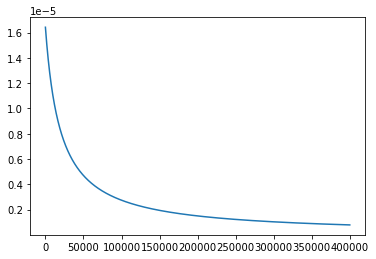

In [238]:
plt.plot(weight)

In [231]:
for count, prediction in enumerate(arr_sorted[sample]):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%50==0:
        pcv.save_checkpoint()

[300698     73]
[161896    108]
[143170    102]
[229317    138]
[265920    144]
[180898    237]
[46291    84]
[106891     31]
[318693     95]
[130082     94]
[159888    100]
[327731    169]
[15579   131]
[44946   144]
[90390    71]
[282145     95]
[65992    73]
[316469    127]
[193180    129]
[278512     14]
[307771    166]
[235025    224]
[1124  177]
[47525    30]
[56886   165]
[280966    177]
[194552     79]
[6561  169]
[169299    142]
[69164   224]
[242833     79]
[44697   177]
[115114    141]
[67688   138]
[293659    104]
[269852     71]
[275867    198]
[66504    56]
[180300     73]
[123898     83]
[172375    142]
[28829    71]
[283298     27]
[307915     82]
[104885     79]
[156818     71]
[276851    199]
[323683    138]
[326487     88]
[85908   121]
[191468      9]
[306656    214]
[216390    127]
[236155     68]
[327408     14]
[67532   224]
[46257    84]
[331504     88]
[19597    16]
[158540     75]
[253802    178]
[123454     35]
[252588    224]
[80265   116]
[334865    169]
[9

[241993    204]
[80146    76]
[56900   165]
[253078    224]
[113821     36]
[128000     30]
[66057   150]
[53438   185]
[192132    123]
[292755     38]
[14819    33]
[273731    138]
[51862    95]
[39988   120]
[279064     86]
[30940    76]
[99811   166]
[13758    98]
[36179    83]
[119686    165]
[70871    95]
[183550     14]
[331364     98]
[160021     86]
[90751    99]
[61522   142]
[124107    138]
[66685    31]
[2454  155]
[323300     76]
[142722     71]
[165567     52]
[13292   185]
[80922    88]
[218031    159]
[279954     95]
[307648    109]
[277995     52]
[107457    165]
[282492      8]
[230681    205]
[18811    62]
[56130   149]
[70650    64]
[261276     36]
[152473     88]
[141844    162]
[66304    48]
[258320     76]
[331602     80]
[263665    122]
[93921   159]
[331261    177]
[334995    139]
[124916     70]
[225063    108]
[38462   142]
[332949    162]
[66937   108]
[138390    127]
[128476     98]
[78293   131]
[67106    79]
[316400     98]
[20634   237]
[88207   194]
[147

[58280   131]
[138946     98]
[326464    159]
[336617    162]
[126791    165]
[113845     99]
[117336    122]
[103548    139]
[66628   191]
[114783    139]
[204086    166]
[91985   104]
[66613    13]
[273764     76]
[130794      8]
[74185    49]
[292541     71]
[92332    88]
[69488    88]
[221090    168]
[277825     73]
[20522   122]
[29011   100]
[68287    73]
[191532     80]
[300128     82]
[17547   100]
[172917     73]
[65079   192]
[172507    138]
[333584     18]
[269788    215]
[55530   185]
[278585    215]
[314876     11]
[326910    109]
[249861    123]
[12643   111]
[151499     84]
[311725    214]
[80064   141]
[126876     75]
[223777     90]
[284044    138]
[173639    144]
[138402     82]
[60509   178]
[76553   194]
[153445    150]
[9048   95]
[280307      6]
[227311    149]
[142907    178]
[1107   71]
[153733     52]
[171134    149]
[255572    138]
[138405     93]
[10566    73]
[209059     86]
[175867    159]
[233267     37]
[9807   71]
[99418   141]
[73899    88]
[128248     

[237985     82]
[120044    128]
[328515     88]
[300879    116]
[326590    158]
[54908   166]
[205126     86]
[3589  169]
[62801   178]
[117516    122]
[76633   159]
[252782    225]
[95796    99]
[145818    100]
[66076   183]
[73805   162]
[51285   169]
[66628   131]
[187835    162]
[219973     79]
[225340     14]
[258270    158]
[269153     76]
[190796    162]
[19405   177]
[79231    76]
[244676    138]
[12457    79]
[141916    165]
[135060     91]
[84393    38]
[125644     76]
[15443    71]
[589 177]
[141223     99]
[78745   100]
[309475    194]
[334131     99]
[145300    224]
[62829   138]
[126213    138]
[59069   169]
[299619    103]
[223507     15]
[43298    94]
[5965   79]
[200051    142]
[161517    142]
[98459   138]
[47456   104]
[191106    142]
[45403    15]
[148744    102]
[244372     79]
[40195   111]
[314808    215]
[312192     89]
[107342    166]
[68194   140]
[236906     98]
[314692    138]
[336446    169]
[66584   224]
[136778    103]
[58003    48]
[200359     14]
[22620

[20132   139]
[102882    169]
[58889   237]
[81171    29]
[67358    95]
[68401    31]
[66407    98]
[67089   131]
[165396     70]
[115948    220]
[280131    161]
[121427    139]
[85369    98]
[280027    165]
[40001   175]
[163612     52]
[317650    128]
[88543   122]
[27281   177]
[148621    100]
[60873    68]
[127059    116]
[318365     71]
[119174    169]
[16409   133]
[68187    13]
[170410    192]
[319519      6]
[159978    150]
[213178     88]
[79629   138]
[223156      6]
[154321    131]
[213279    141]
[227373    205]
[194507    191]
[171929    158]
[272148     53]
[67693   202]
[119529     18]
[212318     36]
[108554    134]
[324119    214]
[297903    178]
[333365    138]
[316782     36]
[273161     76]
[203897     20]
[280375    127]
[64960   116]
[98763   177]
[319815     76]
[67524    72]
[236927    167]
[288461     95]
[68562    72]
[140166     86]
[4685   79]
[32766    84]
[133918    177]
[123880     90]
[8066  127]
[156862    165]
[267493     98]
[82755   140]
[286948     

[302317    103]
[316389     51]
[16187   160]
[68053   224]
[335910     18]
[38868   170]
[54777    73]
[296094     90]
[304406     18]
[322433     48]
[145974    102]
[56382   141]
[103839    144]
[188146     98]
[51897   100]
[137503      9]
[238914    142]
[319131     88]
[66016    54]
[209193    138]
[124780    162]
[320446     84]
[15957   159]
[148471    119]
[93137   133]
[60660   142]
[68007    36]
[217803    170]
[160783    138]
[307805     79]
[24776    86]
[61964    14]
[94518    48]
[56034   138]
[171767    159]
[99251    80]
[82795    36]
[51274   141]
[218203    215]
[71089   131]
[69974   122]
[55620    31]
[111669    149]
[325283    159]
[147571     81]
[316102    167]
[268795     36]
[333668     76]
[66129   196]
[151945    139]
[67758   224]
[306911    138]
[126063    102]
[280556     72]
[301956    177]
[309526    136]
[304390    104]
[43507   165]
[157702    131]
[291932    100]
[81058     9]
[68070    72]
[106047     38]
[166223     68]
[66689    29]
[328450     88

[127407     68]
[156996    170]
[184534    149]
[115279    183]
[129633     98]
[294499     99]
[73863    62]
[300548     86]
[79104    18]
[256592     36]
[166320    160]
[225135    169]
[160467    220]
[260053    136]
[66982   237]
[66308     0]
[9216  160]
[113187    164]
[324916    169]
[333837     91]
[296637     53]
[35879    13]
[222118    178]
[187845    162]
[100102    100]
[334862     83]
[89897    95]
[66872   142]
[310500     82]
[254919    138]
[77514    16]
[146265    131]
[263480     27]
[149955    237]
[23842   139]
[61936    82]
[110003    142]
[332298     95]
[66143    31]
[114973     80]
[121358    214]
[337888    165]
[224436    127]
[235227    113]
[265236     16]
[258342    102]
[1872  162]
[315822     94]
[67208   183]
[295880    116]
[68012    31]
[66826   136]
[277283    125]
[328229    158]
[278976    177]
[82093   171]
[218183    122]
[10124   155]
[262382    191]
[261768     80]
[104985    149]
[194560    191]
[65461   167]
[225757    168]
[298321     49]
[2

[179124    108]
[104987    142]
[275648     70]
[115872     76]
[66240   183]
[252822    178]
[66441   142]
[153742    127]
[16506   169]
[225730     95]
[44536    95]
[256508    138]
[187339    158]
[104521    170]
[163617    127]
[329067     90]
[160538     52]
[50996   155]
[308419    237]
[126805     70]
[86816    14]
[203721     32]
[67210   185]
[281471    194]
[205212      9]
[66419   180]
[127051    141]
[303796    102]
[45550     9]
[312373     51]
[141243    165]
[67092    16]
[67368   178]
[156397     48]
[116537     71]
[278474    165]
[118919     71]
[316847    103]
[176431    139]
[15946   157]
[145894     86]
[127451     86]
[17799    84]
[172379    142]
[321114    113]
[330104    170]
[308793    191]
[270791    149]
[130380    112]
[99412   141]
[251012    138]
[278364    150]
[33273    30]
[211640    100]
[150858     95]
[98542    16]
[282817     73]
[237445      8]
[242052    237]
[68415    16]
[305173    164]
[300833     82]
[300179     79]
[210381    158]
[257972   

[139438     30]
[85795   214]
[285536    237]
[178229    161]
[225146    162]
[160346     73]
[80729    98]
[60947    53]
[67271   150]
[109156     84]
[238691    127]
[230577    194]
[111849    103]
[156523     11]
[173481    215]
[66695    72]
[96098    73]
[82917   121]
[305602     72]
[67617    11]
[153283    138]
[212230    121]
[81199     8]
[33324   225]
[10624   116]
[67117   237]
[147077    161]
[173152     14]
[150322    166]
[320184     65]
[333668     94]
[39988    13]
[4988  220]
[172902     73]
[259013     78]
[72041    72]
[23180    81]
[34533   170]
[206615     80]
[253239     76]
[124926     29]
[336306     76]
[196773    205]
[160542     52]
[162157     94]
[73011   123]
[66663   140]
[337724     71]
[294775     86]
[176488    178]
[160358    131]
[246162    102]
[2158   63]
[63546   177]
[187632     16]
[320641    127]
[163239      8]
[272833     80]
[307133    170]
[144352    121]
[76549   194]
[39870   120]
[67943   222]
[17200    98]
[180944    237]
[140615    127

[152936      9]
[6548  116]
[147092     20]
[166051    236]
[276101     88]
[224626    178]
[304253     95]
[5750   90]
[155187     32]
[14561   169]
[335990     76]
[244827    224]
[279687     71]
[325316     98]
[67489   131]
[336332    138]
[295159    102]
[75400   194]
[131474    170]
[15613   141]
[73894    88]
[50396    79]
[137074    167]
[310285    179]
[30060   142]
[100553    176]
[67229     9]
[109016     94]
[68163   150]
[188212    132]
[44628    88]
[160133    108]
[328692    142]
[313161     76]
[104823     36]
[174537     78]
[176013    144]
[85304   144]
[68097    16]
[252441     52]
[178278    161]
[188143     98]
[212346    162]
[324932    191]
[247113     11]
[281616    100]
[31291    79]
[51088   160]
[66692   150]
[57828    79]
[154421    150]
[220412    100]
[109664    202]
[109326    127]
[40679    75]
[335087      0]
[11393   122]
[306535    178]
[332581     86]
[151431     80]
[270971     36]
[196799    202]
[49915    33]
[92424    99]
[72014   164]
[324157   

[312061     76]
[121421    116]
[139789    141]
[328785    150]
[136457     88]
[225875    180]
[66522    16]
[164164    142]
[12677    64]
[148999     13]
[159417     71]
[296815     46]
[124422     84]
[145098     71]
[327981     98]
[115571    162]
[161511     71]
[335612    139]
[261619    158]
[5898  121]
[158529    191]
[170078    159]
[296255     51]
[240453    131]
[1905  142]
[9351   17]
[296881     15]
[178292    224]
[42048    95]
[308695     29]
[245680    138]
[332295    112]
[31192   112]
[209199    178]
[104333    141]
[205329    144]
[169473     71]
[304672     73]
[327163     91]
[44642   136]
[227999    154]
[268105    194]
[12480   105]
[78463   144]
[169266     36]
[131408    127]
[120451    141]
[299779     95]
[334205    113]
[325529     83]
[323306     98]
[298470    154]
[333880     76]
[271280    136]
[151032    149]
[231632     13]
[66362   224]
[240464    149]
[310469    138]
[73018   128]
[104975     73]
[177008    194]
[127803      6]
[111985    103]
[30791

[86459   127]
[5965   36]
[84397    18]
[104519    162]
[218555    158]
[331383    141]
[101716    103]
[134726    179]
[19867   102]
[45390   166]
[203748    166]
[108774    121]
[60344    48]
[66176   215]
[190728     79]
[144746    158]
[44199    13]
[244050    100]
[9169  138]
[187595    164]
[98161   165]
[286712     95]
[81053    36]
[155127     20]
[16988    48]
[118200    100]
[219800     86]
[215267     29]
[3451   88]
[180795    162]
[605 179]
[38403   164]
[109199     73]
[25427    18]
[167343    123]
[14501   164]
[76632   159]
[1338   71]
[304855     98]
[201987    154]
[17518   109]
[217635    127]
[66129    29]
[305881     76]
[225357      8]
[276332     37]
[67046    48]
[194511    191]
[304951    166]
[183508     14]
[89879   158]
[111984     82]
[54670   142]
[67092   138]
[44746   122]
[237644    144]
[304277    220]
[1815   88]
[317352    103]
[94613   222]
[150685    139]
[109540    141]
[87892   178]
[163592     91]
[46983   139]
[330070     91]
[98477   178]
[190

[180894    237]
[117775    123]
[126149     83]
[206620     76]
[119432    112]
[68586   164]
[11303   122]
[66108   214]
[278290    166]
[324138    196]
[67982   224]
[331776     75]
[257833      8]
[159060    177]
[119192    162]
[137958     88]
[139091     84]
[314106     82]
[68163   131]
[81990    98]
[289527    175]
[13104    90]
[179312    149]
[104641      6]
[67379   215]
[5756   76]
[321687     90]
[101333     78]
[116629    103]
[117975     84]
[47307    84]
[333212     18]
[99558   220]
[318146    103]
[235786    102]
[283421     32]
[80072    99]
[149285     48]
[59166   179]
[124300    191]
[312187    121]
[1919  108]
[27092   180]
[302987     31]
[256367     79]
[63689    70]
[58943   150]
[8470  166]
[103050    192]
[50554   113]
[296538    139]
[165153    169]
[83211   132]
[26197    71]
[19596    11]
[264887     31]
[118241     16]
[90410    11]
[103424     52]
[38272    88]
[169267    175]
[47309    76]
[165303      6]
[332383    112]
[98644   149]
[47357   237]
[671

[228436    102]
[113772    196]
[67489   180]
[144798     53]
[37747    98]
[118012     71]
[336476    177]
[263437     76]
[7469   14]
[101572     56]
[324325    165]
[67812   236]
[101610     14]
[310264    164]
[286965     27]
[63584    82]
[63560   141]
[329721    100]
[235573     73]
[314656    100]
[178274     59]
[161323     78]
[326608    121]
[267292     76]
[115252     14]
[166529     79]
[79976   123]
[114107    162]
[335427     76]
[66483   224]
[314744    170]
[321248    119]
[127701    112]
[59263   116]
[175914    158]
[241962    149]
[309460     98]
[306018    150]
[334865    139]
[2155   62]
[88946    99]
[301420     32]
[217741    170]
[16127   123]
[320640    214]
[69689   122]
[304649     84]
[110980     91]
[133812    171]
[155457    121]
[116741     84]
[67726   131]
[102739     51]
[56409     6]
[200407     14]
[170338     56]
[14988    83]
[94103   104]
[205009    100]
[60992   170]
[65986   138]
[278597    170]
[243562    166]
[25414    38]
[127062     53]
[127

[129011    178]
[294641    222]
[6429   48]
[217251     94]
[251232    160]
[330706     86]
[278682    116]
[337257     53]
[63675   160]
[26843    84]
[109869    103]
[241750    194]
[145089    194]
[318872     90]
[274116    103]
[125652    194]
[36261    76]
[259426     48]
[173438    215]
[153022    170]
[224299    103]
[114177     52]
[17751   100]
[167997    188]
[196469    154]
[218458     75]
[70989   155]
[119480    136]
[247306    202]
[69918    80]
[193096    129]
[143577     81]
[94056   149]
[59069   139]
[57912    84]
[259341     36]
[116035    123]
[75896    98]
[150681    170]
[197512     78]
[172511    138]
[63873    80]
[307577      8]
[304301     56]
[63299    91]
[66262   140]
[333131    138]
[67379   198]
[29865   225]
[314752    177]
[247462     56]
[261840    138]
[161455    175]
[66522   150]
[288289    102]
[200257    141]
[272 220]
[264906    237]
[176507    191]
[66485   164]
[217097     88]
[215622     76]
[66913   224]
[311287    104]
[215995     27]
[12068

[66805   218]
[176081    175]
[72916   116]
[66453    48]
[189222    178]
[90130   149]
[12760   165]
[67546   149]
[322455    116]
[67368   109]
[62475   141]
[281811     49]
[31046   116]
[14285    53]
[3728  112]
[67428   183]
[297717    177]
[245150    123]
[274812    178]
[67231   224]
[313868    102]
[130843    127]
[42483   102]
[115156    220]
[147640     59]
[272542     95]
[284251    100]
[85896   121]
[19401   177]
[258352    171]
[328876    178]
[58532   192]
[744  95]
[156361     51]
[67469   215]
[139993    116]
[80437   160]
[204458    199]
[327470    205]
[333173    179]
[292557     76]
[258475    175]
[57878    36]
[157547     71]
[2340   88]
[283955     32]
[117307    102]
[66930   224]
[18975    11]
[130863    166]
[171809    167]
[303858    220]
[68238    11]
[210618     73]
[76514   131]
[330551     91]
[222342     36]
[59342   188]
[138040     98]
[119526     76]
[306326     32]
[130655    123]
[260980    178]
[308882    233]
[290658    149]
[67469    29]
[205028 

[88141    79]
[85055    76]
[155186    166]
[137717    161]
[66635   196]
[308264     13]
[148986    136]
[301788     67]
[253189    199]
[73611    80]
[183970     80]
[67253   196]
[110208     32]
[296405    116]
[158144    170]
[154338     84]
[83401   149]
[217932    122]
[14787    33]
[147233    179]
[66508   180]
[10634   177]
[282982     11]
[180984    237]
[299108     56]
[240671     27]
[282616    108]
[164239    116]
[55074    49]
[330394    177]
[100160    169]
[32498   139]
[163215    185]
[280828     78]
[177018    194]
[95253   167]
[228793    102]
[36305    91]
[159530    165]
[337487     32]
[44570    95]
[280902    100]
[172184    144]
[67128    36]
[131405     52]
[282258    194]
[255017     79]
[132771    155]
[265499    237]
[99413   220]
[9262  162]
[226310     98]
[280348    225]
[164069    178]
[124622    147]
[161002    138]
[67997    88]
[35895   237]
[219285    103]
[187657     79]
[223538    165]
[41965   170]
[94833    80]
[286767    138]
[294133     71]
[426

[68154   214]
[305701    131]
[11558    36]
[300663    162]
[133780    194]
[22063    80]
[60019   154]
[283158     86]
[249529    167]
[3248   73]
[308197     72]
[122416     84]
[122932     63]
[190208    129]
[332822    170]
[35598    76]
[70051    76]
[150856     95]
[57692   199]
[79850   104]
[39995   178]
[11796   138]
[97971   158]
[291948     76]
[332866    141]
[101752    224]
[200911    191]
[249044    175]
[231462    177]
[220583    177]
[172836     73]
[280624     84]
[143884     71]
[95823   165]
[312242    138]
[67538   155]
[109000    165]
[98632   177]
[68101   214]
[118642     32]
[134414    205]
[171414    142]
[217203     48]
[65190    84]
[203688    144]
[67478    16]
[155642    161]
[296859     90]
[190906    142]
[75898    98]
[327555    147]
[6476  138]
[336684    169]
[80565    82]
[135493     84]
[284104    191]
[190767    205]
[310449    128]
[57562   191]
[40964   123]
[148334     76]
[147108     88]
[300626    139]
[3156  122]
[223839     20]
[132716    127

[103412     52]
[310278     90]
[66041   180]
[71710   141]
[50648    14]
[46144    98]
[322154     84]
[66513   142]
[79060   127]
[167103     51]
[67403    31]
[265920    158]
[129478    162]
[149533     20]
[153977    136]
[283529     88]
[6728  185]
[589 165]
[68332   138]
[119761    170]
[16008    79]
[43804   104]
[295162     98]
[122649    170]
[211776    169]
[14142    78]
[113168     86]
[12352    76]
[23837    84]
[61283    56]
[52322    73]
[308218     90]
[332174     71]
[219712    170]
[306648    123]
[222159     94]
[265852    237]
[311192    130]
[68215   140]
[250135    178]
[34145   162]
[66494   154]
[178102     95]
[172224    167]
[256282     73]
[10199   123]
[3231   99]
[316161    165]
[217082    199]
[65857    91]
[165195    233]
[66470    79]
[171145    175]
[16929   170]
[153326    100]
[156311     80]
[327949     98]
[107611    161]
[258783     98]
[63552    86]
[133976    177]
[157862     98]
[79475    14]
[333250    141]
[211749     90]
[212803    116]
[47229

[95846   128]
[185614    149]
[307346     84]
[67735   214]
[28221    89]
[261984    142]
[102674     95]
[330451     98]
[111033     16]
[76692   155]
[275370    202]
[332351    128]
[333509    138]
[147576     32]
[198046    136]
[151479    116]
[309568     86]
[167913      8]
[94003    84]
[176254    233]
[251773     49]
[151420    170]
[94408   119]
[147014     30]
[12431    67]
[167901      8]
[268833    138]
[85457   194]
[109829    191]
[242387    138]
[267493     84]
[66531   191]
[327217     84]
[299434     84]
[292974     11]
[333907    127]
[128480     98]
[280651    112]
[320107     76]
[122673    111]
[316745     84]
[15931   159]
[122806    139]
[274939    130]
[63231   128]
[69258    82]
[217032     53]
[229650     73]
[165502     48]
[163642    144]
[188202    132]
[328583     76]
[66070   224]
[79552   103]
[223523     15]
[171616     75]
[179272    149]
[126041    139]
[176358     72]
[273601    162]
[29752   179]
[191373    138]
[16171   167]
[94839   198]
[336614   

[261143    194]
[150094      8]
[253332     36]
[15901   198]
[221732    191]
[178598    167]
[44999   180]
[66418    72]
[67068   236]
[115704     76]
[125320    165]
[67855   155]
[136518    160]
[113280     70]
[173629    167]
[87558     9]
[138814     49]
[68467    36]
[167470     95]
[58835    88]
[43004   139]
[226150    113]
[59837    76]
[334211     90]
[169714    111]
[95883   169]
[120007     84]
[152016     73]
[28475   177]
[19759    84]
[74857    82]
[10020    99]
[63558   141]
[90625    46]
[232402    161]
[196696    123]
[226554    183]
[68012   176]
[66231   224]
[261306    178]
[15443    90]
[125802    141]
[281499    138]
[61181   159]
[40003   175]
[66021   120]
[65920    72]
[323028    136]
[98455   180]
[79141    90]
[171606     68]
[68657   176]
[63171   224]
[226137     84]
[173053    150]
[32630   139]
[  0 138]
[89175    31]
[39383    71]
[264031    138]
[92059    75]
[320499    224]
[69398   138]
[283445    100]
[219108    109]
[159059     84]
[86101   144]
[3

[276379    165]
[334200      9]
[115375    139]
[126682    134]
[48920   169]
[102373    220]
[73324    90]
[312398    122]
[50436   149]
[67383   202]
[158587    127]
[236065     46]
[179105    108]
[326118     95]
[251453    214]
[80863   116]
[270791     13]
[317048    189]
[295849    139]
[19824    76]
[42181   165]
[331488    235]
[49909   119]
[287945    224]
[277338    165]
[218292    122]
[66859    31]
[194623      9]
[230701    224]
[297182    154]
[9898  162]
[68046    31]
[247915     99]
[130842    177]
[121395    220]
[310293     51]
[112175    138]
[243598    100]
[155461     88]
[93476   169]
[153906    144]
[229906     11]
[253397     79]
[175020    142]
[283286    127]
[2274  103]
[15814   194]
[45619   220]
[116916    139]
[67438   215]
[337756    169]
[326895     84]
[221732    178]
[82294   138]
[137456     98]
[252345    161]
[68356   164]
[90190    78]
[232494    224]
[234659     99]
[14531   160]
[25261    95]
[325691     72]
[326788    150]
[157162    119]
[19089

[134221    169]
[66683   122]
[130588    159]
[216880    188]
[29248   136]
[122384     76]
[56253   224]
[98703   103]
[12458   154]
[236933    142]
[116697     48]
[66765    48]
[324095    171]
[337743     88]
[180512     36]
[128670     88]
[171019     13]
[117384    102]
[175919    194]
[93296     8]
[67483   176]
[165038     95]
[242403     73]
[66203   133]
[48342   165]
[154180    116]
[76363   128]
[36420   178]
[119396     46]
[207629    100]
[66226   138]
[43388   127]
[160522    159]
[12311    48]
[115450    169]
[66535   198]
[282436     72]
[3913  204]
[222400    188]
[145646     76]
[88081    11]
[154408     71]
[272060    103]
[229102    199]
[75612   167]
[ 9 14]
[98344    63]
[117272    122]
[99400   139]
[68358   138]
[256145    149]
[123908    112]
[313479    122]
[321418     73]
[30052   170]
[73723   119]
[68401   224]
[260078     81]
[263747    178]
[108524     49]
[67600    54]
[125507    138]
[70826    83]
[121946    220]
[155644     14]
[78281   136]
[98133    

[251458     84]
[43055   215]
[63225   113]
[81616   122]
[9464   88]
[170130    144]
[183965     71]
[116701     95]
[226191     52]
[133125     52]
[94832    86]
[319011    169]
[77418   121]
[123019    160]
[138141    102]
[285146    167]
[202687      8]
[215832    127]
[27112   177]
[68560   204]
[139740    170]
[292015      9]
[254554    138]
[141756     84]
[133955    177]
[283636    116]
[107611      8]
[253362    224]
[144739    167]
[110037    169]
[66760    48]
[109558      8]
[17617    91]
[100045     95]
[312691     76]
[67832   150]
[9497   53]
[68488   237]
[13847    86]
[37771   160]
[45012   150]
[317737     36]
[312549     51]
[169263    138]
[272722     78]
[223506    165]
[8919  179]
[218543    171]
[196548    131]
[169870    158]
[73041    73]
[30942    52]
[81859    98]
[78163   131]
[40059    36]
[178219    161]
[67288   215]
[67987   237]
[216573     48]
[330564    146]
[165706     30]
[146713     95]
[72025    98]
[231373    224]
[143892     76]
[179686     36]


[39652   113]
[135294    165]
[250984     11]
[61179   167]
[83690   119]
[103103    175]
[286962     78]
[129830     89]
[64109   119]
[157899    185]
[63387    98]
[66907    16]
[47231    95]
[335127    169]
[298108    194]
[159358     84]
[234380    178]
[66526     0]
[102105    121]
[156568    127]
[175156     13]
[65968   136]
[16122   123]
[318612    149]
[25644    71]
[209212    191]
[172767     73]
[169492     71]
[323655    170]
[326674    116]
[110853    177]
[110320    179]
[240399    225]
[117272     88]
[68560     6]
[301609     95]
[150316      8]
[278221    138]
[66353   123]
[86005    36]
[130652     11]
[116330     80]
[15286   177]
[68245   157]
[67736   140]
[291633    139]
[232100    194]
[313295    116]
[95071   100]
[57024    30]
[28318   177]
[210008     79]
[7350  122]
[129011     79]
[144747    144]
[135357     71]
[283565    177]
[330381    102]
[275593    108]
[66453    35]
[327052    162]
[118625    155]
[67267   131]
[67472   235]
[42879    95]
[115286    1

[156627     70]
[288856    175]
[149634    159]
[221611    191]
[68163   154]
[26238   165]
[105042     73]
[169391    138]
[228324    215]
[311319     88]
[4302   90]
[190552    164]
[273232    164]
[280989    116]
[80845   121]
[241793     73]
[89450    36]
[231077     81]
[201750    191]
[115998     79]
[68024   175]
[118524     82]
[260527     84]
[221094     90]
[109003    165]
[19702    98]
[121126     84]
[78822   194]
[2824   36]
[336613    180]
[150283    121]
[38520    98]
[216319    116]
[191484     80]
[316497     84]
[333230     91]
[75272    31]
[108168     30]
[318536    103]
[227053     29]
[280253    171]
[134431     82]
[256322     73]
[299564    162]
[225318    169]
[56130   120]
[322560    131]
[272450    169]
[81254   179]
[275271    171]
[75290    48]
[66088   142]
[135871    157]
[79566    84]
[127062     94]
[68245   215]
[10624    90]
[63975   144]
[239502    167]
[28955   104]
[305602      6]
[237357    225]
[121214    139]
[71611   139]
[300657      0]
[26936

[166385     46]
[181022    144]
[329846     95]
[122329     76]
[315061    139]
[206858     80]
[122581    121]
[119548     67]
[280111    144]
[207309     14]
[115676    132]
[318930     80]
[118159    160]
[45435    83]
[169520    160]
[227065    165]
[7608   49]
[301589    102]
[4784  162]
[330370     88]
[336476     52]
[188500    149]
[57831   111]
[165168    233]
[299892     67]
[334399    127]
[333226    199]
[217875     14]
[336506     80]
[293389     51]
[275602     90]
[303753    116]
[68422   189]
[68560   237]
[715  31]
[122032    119]
[13907    67]
[170109    167]
[294241    104]
[77203   177]
[198270    178]
[256785    102]
[87989   123]
[274302    178]
[59922    46]
[12798    91]
[104174    147]
[222157    121]
[3562  162]
[207872     73]
[46300    71]
[300504     90]
[148180    127]
[194548     36]
[215157     38]
[10367    80]
[34662   225]
[266980    191]
[154502    122]
[105110     95]
[10641   141]
[99534   165]
[294764    171]
[133886    127]
[148273    235]
[18080

[1352   84]
[115738      8]
[278048    122]
[60513   214]
[66591   214]
[65352   169]
[67152    36]
[95688   119]
[70588   177]
[67057   148]
[66040   133]
[294726    113]
[114761     80]
[67869    11]
[142750     98]
[155919    161]
[34445    54]
[261002    138]
[29534   104]
[103287    121]
[315611     98]
[64244   122]
[100254     95]
[215412     48]
[265024     83]
[110853     52]
[234063    225]
[81749   165]
[46882   230]
[67814   222]
[250718    136]
[57878   202]
[119163     30]
[6973  167]
[105334    100]
[141958     14]
[63575   177]
[67852   131]
[119778    154]
[2161  130]
[146991      8]
[68530   123]
[244580    138]
[311575    177]
[183509     59]
[80444   154]
[16743   136]
[232724     20]
[37495    88]
[4501  214]
[264654    175]
[263539    102]
[133431    144]
[318723    140]
[221788      8]
[285949    215]
[171739    175]
[260403     78]
[136929    154]
[142749     86]
[322559    150]
[225094     99]
[183584      8]
[58893   150]
[170554    144]
[6426  183]
[81430   1

[226187    154]
[305518    170]
[312766     51]
[70201   167]
[304356    214]
[98986   177]
[104977    142]
[48156   164]
[315727     29]
[32383   170]
[330984    170]
[306155     86]
[228367     84]
[226148    141]
[137019    224]
[309981    155]
[121331     71]
[66628   222]
[126005    102]
[67770   128]
[128862    127]
[24114   225]
[5407   79]
[39285   147]
[8183  100]
[221030    136]
[163623    127]
[317114    102]
[302615     30]
[149652     72]
[70590   177]
[329105    103]
[156127    162]
[281992     29]
[210490    149]
[81231    84]
[110848    127]
[52574   214]
[136623     98]
[173041    224]
[42317   139]
[190908    149]
[107130     84]
[77469   116]
[301147    122]
[145808    102]
[164255    122]
[7998  100]
[67872     0]
[68187    48]
[315273    127]
[331857     90]
[136056     98]
[214194     63]
[314822    136]
[89907    75]
[216239    104]
[294293     16]
[66521   155]
[12571    91]
[317793    177]
[7563  159]
[277052     32]
[331659     18]
[138105     98]
[20799    75

[297293     98]
[328872     51]
[251245     51]
[199449    194]
[337592    138]
[302146    215]
[252870     16]
[66322   202]
[237398    175]
[88772    17]
[293538    185]
[75890    84]
[38577    79]
[156649     46]
[42481   225]
[273488    131]
[46398   121]
[100068    100]
[278856      8]
[318765     59]
[30346    95]
[316887     49]
[136546    103]
[234619     36]
[150322      8]
[95034   122]
[67980   109]
[323275    132]
[323348     91]
[35298    90]
[246999     71]
[110687     98]
[334296     76]
[136907     14]
[276351    125]
[316225     98]
[145088    194]
[232123     73]
[123921    113]
[248506    194]
[145444     84]
[66201   199]
[66363    40]
[106317     98]
[28018   169]
[271930     88]
[41773    95]
[238836     73]
[146810     82]
[253637     32]
[109190     73]
[12498     9]
[206616     76]
[268706    164]
[97201   185]
[15980   224]
[127402    112]
[261206     79]
[67155   155]
[155474    121]
[159146    139]
[121140    119]
[131396     52]
[188143     84]
[194290    1

[117657     79]
[258996     32]
[119367    165]
[203464     67]
[87891   138]
[144005    177]
[273242     76]
[1698   98]
[139814    220]
[242323    138]
[2021  214]
[161880     71]
[304650     84]
[270211     48]
[230292     73]
[14106    56]
[118153    116]
[300900     86]
[311004    103]
[199404    194]
[201006    178]
[36012    98]
[89663    84]
[40061    36]
[250353    102]
[6858  167]
[254272     52]
[53416     6]
[245495    237]
[90399   178]
[151644     95]
[207207    158]
[87566   123]
[183520      8]
[284088    165]
[321562    138]
[196758     79]
[138880    116]
[53416   191]
[326625    204]
[15857   215]
[187850    170]
[277291     71]
[60502    79]
[244553    188]
[174173    228]
[302712     82]
[138205    139]
[78825   194]
[333445    170]
[267289    199]
[323045    196]
[313996     82]
[63225    91]
[289665    100]
[219031    138]
[322887    141]
[275270    122]
[68012   191]
[88968   218]
[105734    138]
[136826    100]
[312785     31]
[68579   218]
[76268    90]
[14598

[137572    141]
[66834   224]
[7792   46]
[89671    76]
[147621     51]
[30467    52]
[99698    52]
[76635   194]
[76606   194]
[66192   136]
[294829     71]
[333856    169]
[6433   48]
[190773    169]
[3527  104]
[322450     14]
[187240    141]
[228342    205]
[82462    83]
[100127     31]
[211177    230]
[126304     76]
[127695     90]
[66076   168]
[296668     48]
[146874     67]
[68349   136]
[316428    177]
[106334    171]
[82352     9]
[243978    237]
[98487   144]
[283359    214]
[335192    127]
[240911     14]
[228417    104]
[323571    164]
[333420    138]
[310885     31]
[330679     82]
[312710    123]
[170539    169]
[181664    149]
[73013    73]
[147365    162]
[172694     84]
[70495    13]
[66229   196]
[126901     79]
[71758    54]
[67265   154]
[296550     80]
[335118     75]
[66231   150]
[43441   169]
[321637      9]
[68159   120]
[207624    100]
[39520    90]
[30209    95]
[68215   176]
[164187     88]
[264540    138]
[145263    127]
[175903    158]
[233312    237]
[1

[8998   80]
[15729    91]
[143429     80]
[128317     68]
[30905   170]
[276686      8]
[143896     86]
[20767    73]
[80008   116]
[127465    102]
[194379    158]
[253718    100]
[68378    35]
[82039    76]
[119417     76]
[314808    131]
[300531    116]
[153787     71]
[104884     79]
[67605   224]
[217203     79]
[123991     95]
[246469    138]
[117337     71]
[305524     70]
[118773    116]
[106227     71]
[68535    73]
[104294    113]
[252364    102]
[281608    178]
[22763   169]
[246469     36]
[228158    237]
[154705    122]
[198067    138]
[62885    86]
[93378    18]
[273310    103]
[22914    35]
[105362    166]
[105717    122]
[38573   214]
[141885      9]
[180799     20]
[81764    98]
[48303   236]
[37509   104]
[252361     81]
[129920     71]
[205481    104]
[33968   169]
[310309    220]
[165333    169]
[312969    192]
[27494   177]
[45936    68]
[58238   237]
[704 141]
[62807    36]
[324119    131]
[122906    119]
[255182     36]
[332091      9]
[334901    177]
[67102   222

[221789     32]
[16119   123]
[303218    162]
[159123    165]
[67045   175]
[126873    139]
[300809    178]
[153735     52]
[238609    178]
[148915    166]
[72651   125]
[206852     80]
[68318   148]
[251191    188]
[176492    178]
[221725     13]
[66383    79]
[179206     73]
[331724     36]
[143616     71]
[333645    131]
[256968     73]
[228368     76]
[56889    91]
[326236    121]
[67403   215]
[189221     36]
[68039   204]
[160830     98]
[144191    177]
[35707   132]
[310309    139]
[318930     76]
[303975      8]
[291159     95]
'PUGREST.BadRequest: error: '
[68628   100]
[277631    220]
[298846    150]
[60506   214]
[84410    79]
[244808     11]
[58162   169]
[145893     80]
[160361     48]
[133607    141]
[128924     78]
[206826     86]
[23545    76]
[4050   90]
[191380    138]
[225538     75]
[216447     52]
[144873    128]
[215094     52]
[55069    49]
[2677  100]
[35947   220]
[262218     36]
[171745    185]
[66448   196]
[321959    139]
[88139   123]
[193841    155]
[29038

[109552    141]
[66363   125]
[190776    162]
[40512   169]
[132066    177]
[325135    214]
[328886     94]
[47681    86]
[87158   159]
[44559   100]
[156324     84]
[8660  158]
[309303    103]
[162298     86]
[231914    109]
[58165    98]
[26325   177]
[306611    128]
[294337     95]
[34444   170]
[79058   127]
[81463    76]
[35856    38]
[172980    138]
[98542   204]
[202089    154]
[31687   225]
[336364     51]
[67835    95]
[174545     78]
[63119    93]
[55359   214]
[185590    167]
[75026   112]
[300809    150]
[ 0 73]
[37496   116]
[268722     73]
[65221    52]
[301602    103]
[10800   138]
[231212     73]
[302965    185]
[31797   165]
[313294     88]
[74528    32]
[226470     98]
[331493    165]
[149856    139]
[311062    235]
[297314    171]
[78281   140]
[234848     80]
[169586     53]
[176089    175]
[66046   128]
[65913    72]
[55849   136]
[246144    102]
[41660    76]
[111382    162]
[332209     88]
[158688     68]
[329468    116]
[67202    89]
[127383     68]
[55358    84

[66155     0]
[67483   204]
[263654     36]
[302061    161]
[244211    175]
[84423    18]
[219952    138]
[308041     84]
[85295    32]
[66819   178]
[114424      8]
[145301    131]
[159070      6]
[55973   185]
[136815     98]
[108793     49]
[161209    158]
[335524     90]
[39989   148]
[187313    159]
[68208   149]
[224405    171]
[81816    11]
[226446     76]
[65081   192]
[6446   84]
[248377     81]
[65939    11]
[66629    31]
[99531   165]
[15137    51]
[255481      8]
[41918   165]
[312432     71]
[16158   127]
[275371     88]
[196742    123]
[242368     51]
[79313    90]
[147330     17]
[148203     52]
[152693    138]
[167879      8]
[248806    149]
[147310     37]
[63283    90]
[66982   214]
[267705     52]
[145916    131]
[167909     32]
[22790    86]
[325260    158]
[159979    214]
[4208  180]
[263194     60]
[50979   138]
[194509    191]
[169575     53]
[259707    215]
[243866    224]
[255358    235]
[85061    76]
[103821    144]
[305620     56]
[294230     11]
[41893    95

[108078    121]
[235378    128]
[298355     88]
[66129    73]
[157054    165]
[145230    165]
[170804     36]
[40065   178]
[160055    139]
[151  13]
[317993     76]
[188808    149]
[117362    121]
[258173     84]
[68450   142]
[45559    84]
[314043     75]
[234023     46]
[66511   140]
[10712    49]
[67174     6]
[204482    199]
[67241    89]
[303283     38]
[127059     88]
[18588   165]
[58950   178]
[50652    14]
[71377   138]
[315000    169]
[68051   154]
[332211     84]
[217687    170]
[2231   71]
[307042    192]
[67332   138]
[173010     36]
[307953     84]
[147792    119]
[326228    122]
[7171   34]
[104999    142]
[17129    79]
[125603     11]
[69161   128]
[67610   103]
[296627     98]
[200056    149]
[302755     32]
[223991     98]
[206600     76]
[63198    33]
[328187     76]
[50875   158]
[124459     80]
[223037     98]
[315063    139]
[277787    165]
[175953    158]
[49529    84]
[76819    76]
[12846    67]
[73684   121]
[258474     11]
[128914     78]
[118215    131]
[697

[67617   205]
[85384   194]
[135537    162]
[306977    121]
[328834      6]
[217614     52]
[80840   122]
[245224    138]
[67178   136]
[15417    72]
[76091    30]
[275895    103]
[104839     73]
[151940     95]
[66023   136]
[125555      6]
[115140     71]
[160918     98]
[283701    149]
[21814    93]
[316035    127]
[111496    102]
[85714   158]
[257773    175]
[67374   183]
[220422     88]
[127543    100]
[10197   141]
[212647     63]
[150535     76]
[16082   103]
[111030    178]
[288027    128]
[68051   150]
[56892   103]
[161629    220]
[110845    169]
[311673    100]
[249704     99]
[124780    139]
[96574    14]
[91000   194]
[165180    233]
[123830     86]
[156425    133]
[15953   194]
[66675    48]
[160543     52]
[272660    169]
[107312    165]
[144741    144]
[149283     11]
[187611     79]
[280854    138]
[267006    123]
[256468     38]
[17570    83]
[329033      9]
[76115   162]
[316391     84]
[140155     98]
[66780   109]
[124710     71]
[252044     71]
[248915    194]
[1

# Now to sample some even lower probability predictions:

In [256]:
#take a random sample of assays across the (many) higher probability ones:
n = 2_000_000
take = 30000

weight = 1 / (np.arange(n)/take+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False) + 400_000

<AxesSubplot:>

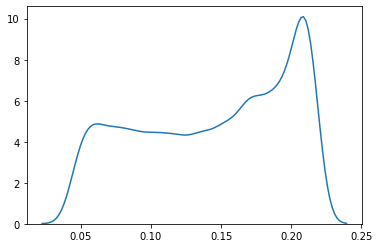

In [257]:
kdeplot(probability_arr[arr_sorted[sample][:,0], arr_sorted[sample][:,1]] )

In [ ]:
for count, prediction in enumerate(arr_sorted[sample]):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%50==0:
        pcv.save_checkpoint()

[167715    183]
[58706    48]
[304621     84]
[294819     93]
[186117     16]
[3169   36]
[232161    131]
[138937    131]
[193822    136]
[76360   175]
[161414    237]
[200949    224]
[191349    138]
[196738     11]
[160897    103]
[265533    138]
[187644    125]
[261681     36]
[311642     90]
[171196     36]
[287951    118]
[67699   236]
[40066   120]
[257879    199]
[207722    149]
[194148     11]
[264431     16]
[226247    164]
[120129    125]
[90541     9]
[314222     83]
[20272   158]
[102571     22]
[332576    126]
[186078     72]
[136703    159]
[80206    72]
[189938    180]
[201826     16]
[220962     35]
[205719    131]
[191337    140]
[261249     11]
[324025     71]
[57829   126]
[238644    202]
[261266    131]
[190757     35]
[62776   176]
[1127   35]
[2527  128]
[312003    179]
[112847    235]
[51411    76]
[228091     13]
[239211    183]
[315207    150]
[77924    36]
[149283    236]
[2962   29]
[91842   192]
[57466   237]
[94056   101]
[225733     16]
[246102    123]
[224

[250720    125]
[312092    166]
[334564     38]
[135816     93]
[248608     84]
[67873   157]
[250476    136]
[69401   222]
[78630   183]
[93834   128]
[265424     79]
[88813   160]
[117620     72]
[61882    16]
[90471    91]
[149678    128]
[189083    146]
[277909     16]
[118583     86]
[171452    131]
[137011    155]
[66185   154]
[175721     16]
[256221    133]
[104137    128]
[8090   13]
[224914     89]
[75620    27]
[67430   178]
[300862    192]
[195885     36]
[228529    194]
[106303    112]
[35165    84]
[291700    239]
[238759    123]
[190628    128]
[289165     89]
[38223    79]
[234931    178]
[254847    158]
[243232     36]
[270993    178]
[134073     80]
[217966     86]
[114417    138]
[67379   167]
[42418    46]
[229566    218]
[264287    133]
[51812   170]
[328106     91]
[290628    128]
[135201    138]
[120973     98]
[12658    53]
[44640   123]
[180971     36]
[261139    131]
[68558   176]
[149367     79]
[219309     53]
[189904     79]
[307489     40]
[94697     9]
[2

[199798    196]
[90661   130]
[9039  128]
[100882    128]
[255819    128]
[147746     36]
[308739     16]
[17099   150]
[310890    138]
[67507   196]
[75264   180]
[194581     72]
[59530     9]
[228120    154]
[315281    105]
[196547     89]
[276404     11]
[247610    178]
[147589    142]
[66714   199]
[279914    105]
[215262    179]
[93991    53]
[20598   131]
[81213   192]
[243010     91]
[27939    90]
[120203    128]
[259861     41]
[63611   222]
[120977     38]
[50440   224]
[4893  204]
[4764  236]
[67448    20]
[313605    123]
[269897     48]
[136671     53]
[142953     76]
[238628    160]
[283533    161]
[16763   131]
[196164    128]
[224751     79]
[169257     36]
[80988   160]
[169322     13]
[191165     11]
[321212    176]
[48595    14]
[65196   183]
[245518    160]
[311236     89]
[308485    133]
[221200    180]
[152200    164]
[295835    146]
[4503   29]
[175753    214]
[194340    149]
[239326    204]
[260316    189]
[153296     93]
[281998    164]
[114360     31]
[71342   1

[198438    109]
[85038    18]
[206142     98]
[224285    204]
[280438     82]
[136773    105]
[317236     71]
[241270    224]
[236374     11]
[51402   105]
[60057   183]
[223253    131]
[70953    16]
[188816    224]
[102088     86]
[307565     36]
[176520    204]
[124759    126]
[16053    69]
[289504     16]
[52735   123]
[333710     57]
[211901     94]
[250794     73]
[2163   36]
[112601    105]
[63417   148]
[48027   171]
[230868    150]
[65246    27]
[196541    164]
[225079    123]
[186735    180]
[248126    159]
[166926    154]
[326732    128]
[306102    125]
[282971     17]
[22432    90]
[277453     82]
[205008    179]
[261808    171]
[305461     57]
[10094   105]
[268753     53]
[413 176]
[91809    53]
[183415    164]
[63875   166]
[52832   149]
[63585    75]
[173037    218]
[130245     11]
[32159    73]
[232682     16]
[1367  123]
[224028     35]
[17384    98]
[76699    11]
[286767     72]
[253050    175]
[119440     29]
[78653   126]
[287987     72]
[204193     79]
[312150    1

[78287   218]
[63871   133]
[175173    180]
[212656     36]
[219938     31]
[294405    183]
[228929    136]
[96103   155]
[111034    222]
[277389     16]
[260031    224]
[161468    222]
[141211     22]
[12047   101]
[146525    224]
[176270    157]
[79084    10]
[335013     29]
[51478    86]
[18195    35]
[328263     93]
[82796   178]
[115982     72]
[218873    159]
[98945   222]
[262115     11]
[126776    160]
[282954    204]
[195701    118]
[330338     76]
[314178      0]
[220650    103]
[195805    136]
[277937    205]
[112756    180]
[81888   150]
[216090    126]
[190641    154]
[66028   172]
[178511     31]
[72326   131]
[94099    57]
[60493    16]
[126700     41]
[20374   125]
[246661    138]
[279375    237]
[295173     36]
[118581     76]
[259048    131]
[201840    118]
[147622     89]
[309334    173]
[215099     18]
[3306  133]
[267579    180]
[252935    131]
[104859     89]
[109906    180]
[69905    31]
[174128    175]
[280720     79]
[191462     15]
[234091    133]
[142783    1

[138487     18]
[40938    41]
[14794   179]
[261570    178]
[188574    128]
[84114   130]
[7510  178]
[270393     89]
[228484    123]
[328880    222]
[178858     38]
[141746     53]
[265490    123]
[66950    89]
[251591    149]
[196479    138]
[288447    222]
[90161   138]
[242019    164]
[322375    204]
[256483     11]
[299007    154]
[41236   166]
[68031   155]
[66437   192]
[111376     31]
[200971    131]
[301992     29]
[217751    171]
[328707    160]
[72587   181]
[35864    84]
[171354    164]
[20009   123]
[304919    123]
[154329     38]
[124189     22]
[264623    138]
[3216   11]
[92976    84]
[229076    157]
[74278    79]
[161574     35]
[167465    214]
[207868    199]
[320360     11]
[15126   130]
[169315    218]
[72663    36]
[70670    79]
[281346    131]
[43303    71]
[289535    138]
[202421     11]
[79648   224]
[284816     36]
[10425     9]
[128021     16]
[316361     55]
[67873    89]
[200284    138]
[148107     72]
[78620    48]
[39946   196]
[98829   118]
[85678   138]
